# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Dimensionality reduction](#Dimensionality-reduction)
* [Results](#Results)

# Introduction

To speed development, 5-fold train-test splits were preprocessed and prepared as separate .feather files. Outliers were removed from training data using LocalOutlierFactor in a previous notebook. This notebook further preprocesses the data by using Linear Discriminant Analysis to generate two components. The resultant components may be considered newly extracted features or perhaps may be sufficient without the FRILL embeddings.

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import pandas as pd

# utility
from gc import collect as gc_collect

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# Linear Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 2.3 s


In [4]:
# Location of CV .feather files
CV_FEATHERS_FOLDER = "."

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 115 ms


# Dimensionality reduction

In [5]:
fold_num = 0
while True:
    fold_begin = time()

    # load training data
    try:
        X_train: pd.DataFrame = pd.read_feather(
            f"{CV_FEATHERS_FOLDER}/cv_{fold_num}/X_train_LOF.feather"
        )
        y_train: pd.Series = pd.read_feather(
            f"{CV_FEATHERS_FOLDER}/cv_{fold_num}/y_train_LOF.feather"
        ).iloc[:, 0]
    except FileNotFoundError:
        break

    # fit LDA
    reducer = LinearDiscriminantAnalysis().fit(X_train, y_train.values.ravel())
    del y_train
    _ = gc_collect()

    # save X_train
    idx = X_train.index
    X_train = pd.DataFrame(reducer.transform(X_train))
    X_train.index = idx
    del idx
    _ = gc_collect()
    X_train.columns = ["LDA1", "LDA2"]
    X_train.to_feather(f"{DATA_OUT_FOLDER}/cv_{fold_num}/X_train_LOF-LDA.feather")
    del X_train
    _ = gc_collect()

    # load & save X_test
    X_test = pd.read_feather(
        f"{CV_FEATHERS_FOLDER}/cv_{fold_num}/X_test_untransformed.feather"
    )
    idx = X_test.index
    X_test = pd.DataFrame(reducer.transform(X_test))
    del reducer
    _ = gc_collect()
    X_test.index = idx
    del idx
    _ = gc_collect()
    X_test.columns = ["LDA1", "LDA2"]
    X_test.to_feather(f"{DATA_OUT_FOLDER}/cv_{fold_num}/X_test_LOF-LDA.feather")
    del X_test
    _ = gc_collect()

    print(f"fold {fold_num + 1} completed in {time() - fold_begin:.2f} s")
    fold_num += 1
    del fold_begin
    _ = gc_collect()

fold 1 completed in 52.84 s
fold 2 completed in 53.16 s
fold 3 completed in 47.92 s
fold 4 completed in 44.19 s
fold 5 completed in 49.85 s
time: 4min 8s


# Results

Let's peek at the results.

,LDA1,LDA2
0,-0.528231,-0.289786
1,-1.347100,0.531303
2,-0.820677,-0.848767
3,-1.192168,-0.155558
4,-1.554612,-0.648507


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72179 entries, 0 to 72178
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LDA1    72179 non-null  float64
 1   LDA2    72179 non-null  float64
dtypes: float64(2)
memory usage: 1.1 MB


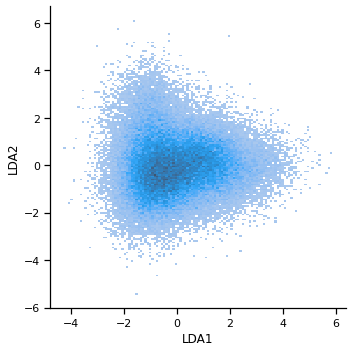

,LDA1,LDA2
0,-1.548572,-0.688380
1,-1.140493,0.910110
2,-1.005166,0.150548
3,-0.230662,-0.734625
4,-0.120888,-0.598590


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11524 entries, 0 to 11523
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LDA1    11524 non-null  float64
 1   LDA2    11524 non-null  float64
dtypes: float64(2)
memory usage: 180.2 KB


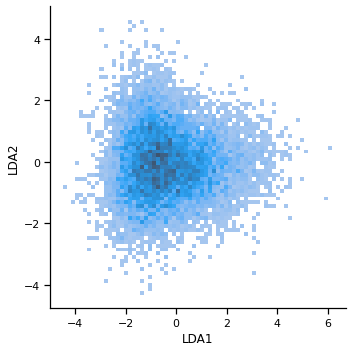

time: 563 ms


In [8]:
_ = pd.read_feather("./cv_0/X_train_LOF-LDA.feather")
_.head(5)
_.info()

sns.displot(x=_.LDA1, y=_.LDA2, palette="colorblind")
sns.despine(**dict.fromkeys(["top", "right"], True))
plt.show()

_ = pd.read_feather("./cv_1/X_test_LOF-LDA.feather")
_.head(5)
_.info()

sns.displot(x=_.LDA1, y=_.LDA2, palette="colorblind")
sns.despine(**dict.fromkeys(["top", "right"], True))
plt.show()

In [7]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 257.27732276916504 s
time: 116 ms


[^top](#Contents)